# Choroid Plexus and Thalamic Nuclei

## Setup

Formatting

<style>
body, .jp-Notebook {
    font-family: 'Source Sans 3', serif !important;
}


table {
    font-family: 'Source Sans 3', sans-serif;
}

table td, table th {
    text-align: center !important;
}

/* Optional: keep first column left-aligned if it contains labels */
table td:first-child, table th:first-child {
    text-align: left !important;
}
</style>

### Imports

In [124]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
from pathlib import Path
from IPython.display import clear_output

import os
import numpy as np
import statsmodels.api as sm
from scipy import stats
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import subprocess

from reload_recursive import reload_recursive
import sys

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace

In [125]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

import utils
from utils import load_df, zscore, get_colors
from my_namespace import (
    presentation_cols
)
from my_namespace import *

import regression_utils as regutils
from regression_utils import (
    quick_regression,
    quick_regression2,
    residualize_vars,
    run_regressions,
)

### Load Data

#### Clinical and Volumes

In [126]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/4-CP_and_medial_posterior_atrophy"
)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

data = utils.load_data("/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv")

# dataT = pd.read_csv(
#     "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data_transformed.csv",
#     index_col="subid",
# )

MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

data_ms = data[MS_patients]
data_ms_z = zscore(data_ms)
    
    
grouped_nuclei = [
    "medial",
    "posterior",
    "ventral",
    "anterior"
] 

nuclei_rename_index = {
    k: f"**{k}**" for k in grouped_nuclei
}

### Functions

In [127]:
def run_R_script(p1, p2, p12, nobs):
    """
    Call R script to run Williams-Hotelling test and return p-value.

    Parameters:
    -----------
    p1 : float
        First correlation coefficient
    p2 : float
        Second correlation coefficient
    p12 : float
        Correlation between the two variables
    nobs : int
        Number of observations

    Returns:
    --------
    float
        The p-value from the Williams-Hotelling test
    """
    # Path to the R script (adjust this to where your R script is located)
    r_script_path = "/home/srs-9/Projects/ms_mri/analysis/thalamus/run_williams_hotelling.R"

    # Convert arguments to strings
    args = [str(p1), str(p2), str(p12), str(nobs)]

    # Call R script
    try:
        result = subprocess.run(
            ["Rscript", r_script_path] + args,
            capture_output=True,
            text=True,
            check=True,
        )

        # Parse the output (p-value)
        p_value = float(result.stdout.strip())
        return p_value

    except subprocess.CalledProcessError as e:
        print(f"Error running R script: {e}")
        print(f"stdout: {e.stdout}")
        print(f"stderr: {e.stderr}")
        raise
    except ValueError as e:
        print(f"Error parsing R output: {e}")
        print(f"R output was: {result.stdout}")
        raise


def thalamus_influence_analysis(model_data, influenced_var, covariates):
    residualized_vars = {}
    for var in ["medial", "posterior", "anterior", "ventral", "THALAMUS_1"] + [
        influenced_var
    ]:
        residualized_vars[var] = residualize_vars(
            model_data,
            dependent_var=var,
            independent_vars=covariates,
        )

    residualized_vars = pd.DataFrame(residualized_vars).dropna()

    nobs = residualized_vars[influenced_var].shape[0]

    structs = ["medial", "posterior", "anterior", "ventral"]
    working_structs = structs.copy()

    nuclei_comps = {}
    thalamus_comps = {}
    pearson_results = {}
    pearson_results["THALAMUS_1"] = stats.pearsonr(
        residualized_vars["THALAMUS_1"], residualized_vars[influenced_var]
    )
    for i, struct in enumerate(structs):
        pearson_results[struct] = stats.pearsonr(
            residualized_vars[struct], residualized_vars[influenced_var]
        )

        thalamus_comps[f"{struct} vs THALAMUS_1"] = run_R_script(
            pearson_results["THALAMUS_1"][0],
            pearson_results[struct][0],
            stats.pearsonr(residualized_vars["THALAMUS_1"], residualized_vars[struct])[
                0
            ],
            nobs,
        )
        if thalamus_comps[f"{struct} vs THALAMUS_1"] >= 0.05:
            sign = "="
        elif abs(pearson_results[struct][0]) > abs(pearson_results["THALAMUS_1"][0]):
            sign = ">"
        else:
            sign = "<"
        thalamus_comps = {re.sub(r"vs", sign, k): v for k, v in thalamus_comps.items()}

    for i, struct1 in enumerate(structs):
        working_structs = working_structs[1:]
        for struct2 in working_structs:
            nuclei_comps[f"{struct1} vs {struct2}"] = run_R_script(
                pearson_results[struct1][0],
                pearson_results[struct2][0],
                stats.pearsonr(residualized_vars[struct1], residualized_vars[struct2])[
                    0
                ],
                nobs,
            )
            if nuclei_comps[f"{struct1} vs {struct2}"] >= 0.05:
                sign = "="
            elif abs(pearson_results[struct1][0]) > abs(pearson_results[struct2][0]):
                sign = ">"
            else:
                sign = "<"
            nuclei_comps = {re.sub(r"vs", sign, k): v for k, v in nuclei_comps.items()}

    return pearson_results, thalamus_comps, nuclei_comps


def thalamus_influence_analysis_all_nuclei(model_data, influenced_var, covariates):
    residualized_vars = {}
    for var in hips_thomas_ref[thalamic_nuclei].to_list() + [
        "THALAMUS_1", influenced_var
    ]:
        residualized_vars[var] = residualize_vars(
            model_data,
            dependent_var=var,
            independent_vars=covariates,
        )

    residualized_vars = pd.DataFrame(residualized_vars).dropna()

    nobs = residualized_vars[influenced_var].shape[0]

    structs = hips_thomas_ref[thalamic_nuclei]
    working_structs = structs.copy()

    thalamus_comps = {}
    pearson_results = {}
    pearson_results["THALAMUS_1"] = stats.pearsonr(
        residualized_vars["THALAMUS_1"], residualized_vars[influenced_var]
    )
    for i, struct in enumerate(structs):
        pearson_results[struct] = stats.pearsonr(
            residualized_vars[struct], residualized_vars[influenced_var]
        )

        thalamus_comps[f"{struct} vs THALAMUS_1"] = run_R_script(
            pearson_results["THALAMUS_1"][0],
            pearson_results[struct][0],
            stats.pearsonr(residualized_vars["THALAMUS_1"], residualized_vars[struct])[
                0
            ],
            nobs,
        )
        if thalamus_comps[f"{struct} vs THALAMUS_1"] >= 0.05:
            sign = "="
        elif abs(pearson_results[struct][0]) > abs(pearson_results["THALAMUS_1"][0]):
            sign = ">"
        else:
            sign = "<"
        thalamus_comps = {re.sub(r"vs", sign, k): v for k, v in thalamus_comps.items()}

    return pearson_results, thalamus_comps

## Results section 4

**CP enlargement is associated with medial thalamic atrophy**

### Associations with overall thalamic atrophy

In [ ]:
model_data = zscore(data[MS_patients])
save_path = fig_path / "combined_nuclei_thalamus_control_by_struct.xlsx"
covariates = ["age", "Female", "tiv"]

outcomes = ["WTV"]

predictor = ["CP", "T2LV_log1p", "WBV", "WMV", "GMV", "cortical_thickness"]


results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictor,
    covariates,
)


for outcome in outcomes:
    results_to_display = results[outcome]
    display_order = results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"`{outcome} ~ *predictor* + {" + ".join(covariates)}`"))
    display(
        Markdown(regutils.present_model(results_to_display, presentation_cols).to_markdown())
    )

WBV, age, Female, tiv, WTV
WMV, age, Female, tiv, WTV
GMV, age, Female, tiv, WTV


`WTV ~ *predictor* + age + Female + tiv`

| predictor          |    coef |   p_fdr |     se | ci              |   R2 |
|:-------------------|--------:|--------:|-------:|:----------------|-----:|
| CP                 | -0.4179 | 8.5e-19 | 0.0471 | [-0.51, -0.326] | 0.43 |
| T2LV_log1p         | -0.5707 | 3.9e-43 | 0.0413 | [-0.652, -0.49] | 0.59 |
| WBV                |  1.4773 | 8.1e-67 | 0.085  | [1.31, 1.64]    | 0.67 |
| WMV                |  1.06   | 3.1e-46 | 0.0739 | [0.915, 1.2]    | 0.54 |
| GMV                |  0.9452 | 3.1e-13 | 0.1297 | [0.691, 1.2]    | 0.53 |
| cortical_thickness |  0.6055 | 4.8e-36 | 0.0482 | [0.511, 0.7]    | 0.57 |

### Associations with regional atrophy

**Other variables predict different patterns of regional atrophy**

To determine if this medial atrophy pattern was nonspecifically related to other markers of cerebral inflammatory burden, we repeated these assessments with total T2LV, the total number of paramagnetic rim lesions (PRL), and ventricle volumes. T2LV predicted excess atrophy in the posterior and sparing of the ventral nuclei, and PRL predicted atrophy in the posterior (Table 4). Other than CP, only LV and third ventricle volumes predicted excess medial atrophy. 

T2LV predicts regional atrophy of all but medial nuclei. WMV predicts medial and ventral atrophy

In [28]:
model_data = data_ms_z
# model_data = zscore(dataT[MS_patients])
save_path = fig_path / "combined_nuclei_thalamus_control_by_struct.xlsx"
covariates = ["THALAMUS_1", "age", "Female", "tiv"]

outcomes = [
    "medial",
    "posterior",
    "ventral",
    "anterior"
]

predictor = ["CP", "t2lv_log"]
# predictor = ["CP", "t2lv", "PRL", "LV", "thirdV", "CCR"]


results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictor,
    covariates,
    to_check_vif=False,
)

exog_list = ["HAS_PRL", "WTV", "age", "Female", "tiv"]
prl_results = {}
for outcome in outcomes:
    prl_results[outcome], _, _ = regutils.run_regressions_multimodel(model_data, outcome, [exog_list], to_check_vif=False)
    results[outcome].loc['PRL 1+', :] = prl_results[outcome]['0'].loc["HAS_PRL[T.1]", :]

exog_list = ["PRL_LEVEL", "WTV", "age", "Female", "tiv"]
prl_results = {}
for outcome in outcomes:
    prl_results[outcome], _, _ = regutils.run_regressions_multimodel(model_data, outcome, [exog_list], to_check_vif=False)
    results[outcome].loc['PRL 3+', :] = prl_results[outcome]['0'].loc["PRL_LEVEL[T.2]", :]



for outcome_to_display in outcomes:
    results_to_display = results[outcome_to_display]
    display_order = results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"`{outcome_to_display} ~ *predictor* + {" + ".join(covariates)}`"))
    display(
        Markdown(regutils.present_model(results_to_display, presentation_cols).to_markdown())
    )


save_path = fig_path / "nuclei_group_regressions.xlsx"
with pd.ExcelWriter(save_path, mode='a', if_sheet_exists='replace') as writer:
    for outcome_to_display in outcomes:
        results_to_display = results[outcome_to_display]
        regutils.present_model(results_to_display, presentation_cols).to_excel(writer, sheet_name=outcome_to_display)

`medial ~ *predictor* + THALAMUS_1 + age + Female + tiv`

| predictor   |    coef |   p_fdr |     se | ci                |   R2 |
|:------------|--------:|--------:|-------:|:------------------|-----:|
| CP          | -0.0739 | 0.00056 | 0.0203 | [-0.114, -0.034]  | 0.89 |
| t2lv_log    | -0.0206 | 0.3     | 0.0198 | [-0.0594, 0.0182] | 0.89 |
| PRL 1+      |  0.0279 | 0.51    | 0.0352 | [-0.0411, 0.0969] | 0.89 |
| PRL 3+      |  0.0567 | 0.51    | 0.0625 | [-0.0659, 0.179]  | 0.89 |

`posterior ~ *predictor* + THALAMUS_1 + age + Female + tiv`

| predictor   |    coef |   p_fdr |     se | ci                 |   R2 |
|:------------|--------:|--------:|-------:|:-------------------|-----:|
| CP          | -0.0459 | 0.01    | 0.0178 | [-0.0809, -0.0109] | 0.9  |
| t2lv_log    | -0.0709 | 0.00096 | 0.0203 | [-0.111, -0.0311]  | 0.91 |
| PRL 1+      | -0.0629 | 0.061   | 0.0336 | [-0.129, 0.00288]  | 0.9  |
| PRL 3+      | -0.1829 | 0.00057 | 0.0518 | [-0.284, -0.0814]  | 0.91 |

`ventral ~ *predictor* + THALAMUS_1 + age + Female + tiv`

| predictor   |   coef |   p_fdr |     se | ci                |   R2 |
|:------------|-------:|--------:|-------:|:------------------|-----:|
| CP          | 0.1309 | 4.6e-11 | 0.0196 | [0.0925, 0.169]   | 0.87 |
| t2lv_log    | 0.0864 | 0.00073 | 0.0256 | [0.0363, 0.137]   | 0.87 |
| PRL 1+      | 0.0146 | 0.72    | 0.0402 | [-0.0642, 0.0933] | 0.86 |
| PRL 3+      | 0.1111 | 0.12    | 0.0673 | [-0.0209, 0.243]  | 0.86 |

`anterior ~ *predictor* + THALAMUS_1 + age + Female + tiv`

| predictor   |    coef |   p_fdr |     se | ci                 |   R2 |
|:------------|--------:|--------:|-------:|:-------------------|-----:|
| CP          |  0.0428 |   0.33  | 0.0439 | [-0.0432, 0.129]   | 0.56 |
| t2lv_log    | -0.0878 |   0.056 | 0.04   | [-0.166, -0.00941] | 0.57 |
| PRL 1+      | -0.0509 |   0.56  | 0.0704 | [-0.189, 0.0871]   | 0.56 |
| PRL 3+      | -0.1732 |   0.2   | 0.1102 | [-0.389, 0.0428]   | 0.56 |

In [ ]:
model_data = data_ms_z
all_covariates = {
    "basic": ["age", "Female", "tiv"],
    "WTV": ["WTV", "age", "Female", "tiv"],
    "WBV": ["WBV", "age", "Female", "tiv"]
}

predictors = ["CP", "T2LV_log1p", "WBV", "WMV", "GMV", "cortical_thickness"]

all_results = {}
all_models = {}
for name, covariates in all_covariates.items():
    outcomes = [
        "medial",
        "posterior",
        "ventral",
        "anterior"
    ]

    predictor = [pred for pred in predictors if pred not in covariates]

    results, _, models = regutils.run_regressions(
        model_data,
        outcomes,
        predictor,
        covariates,
        to_check_vif=False,
    )
    all_results[name] = results
    all_models[name] = models


save_cols = ["coef", "ci", "p_fdr"]


for view in all_covariates:
    results = all_results[view]
    save_path = fig_path / f"combined_nuclei_{view}_control_by_struct.xlsx"

    with pd.ExcelWriter(save_path) as writer:
        for predictor in results:
            save_results = results[predictor][save_cols]
            save_results.to_excel(writer, sheet_name=predictor)


    for outcome_to_display in outcomes:
        results_to_display = results[outcome_to_display]
        display_order = results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
        display(Markdown(f"`{outcome_to_display} ~ *predictor* + {" + ".join(all_covariates[view])}`"))
        display(
            Markdown(regutils.present_model(results_to_display, presentation_cols).to_markdown())
        )
    display(Markdown("---"))


### CP predicts regional thalamic atrophy

**CP predicted thalamic atrophy in the medial and posterior nuclei beyond what could be explained by overall thalamic size.**

To determine relative tissue atrophy distribution within the thalamus, the same multivariable approach was applied to thalamic nuclei volumes with WTV as an additional covariate. CP predicted atrophy of the medial (β=-0.076, p<0.001) and posterior (β=-0.04, p=0.016) nuclei groups, and it was associated with sparing of the ventral nuclei groups (β=0.13, p<0.001). There was no significant association with the anterior nucleus. 

In [20]:
model_data = data_ms_z
save_path = fig_path / "combined_nuclei_thalamus_control_by_struct.xlsx"
covariates = ["WTV", "age", "Female", "tiv"]

outcomes = [
    "medial",
    "posterior",
    "ventral",
    "anterior"
]

predictor = ["CP", "T2LV_log1p", "WBV"]

_, results, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictor,
    covariates,
    to_check_vif=False,
)


for predictor_to_display in predictor:
    results_to_display = results[predictor_to_display]
    display_order = results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"`outcome ~ *{predictor_to_display}* + {" + ".join(covariates)}`"))
    display(
        Markdown(regutils.present_model(results_to_display, presentation_cols).to_markdown())
    )

`outcome ~ *CP* + WTV + age + Female + tiv`

| outcome   |    coef |   p_fdr |     se | ci                 |   R2 |
|:----------|--------:|--------:|-------:|:-------------------|-----:|
| medial    | -0.0739 | 0.00056 | 0.0203 | [-0.114, -0.034]   | 0.89 |
| posterior | -0.0459 | 0.013   | 0.0178 | [-0.0809, -0.0109] | 0.9  |
| ventral   |  0.1309 | 9.1e-11 | 0.0196 | [0.0925, 0.169]    | 0.87 |
| anterior  |  0.0428 | 0.33    | 0.0439 | [-0.0432, 0.129]   | 0.56 |

`outcome ~ *T2LV_log1p* + WTV + age + Female + tiv`

| outcome   |    coef |   p_fdr |     se | ci                |   R2 |
|:----------|--------:|--------:|-------:|:------------------|-----:|
| medial    |  0.0062 | 0.8     | 0.0244 | [-0.0417, 0.054]  | 0.89 |
| posterior | -0.0951 | 5.7e-06 | 0.0197 | [-0.134, -0.0565] | 0.91 |
| ventral   |  0.092  | 0.00048 | 0.025  | [0.0429, 0.141]   | 0.87 |
| anterior  | -0.1459 | 0.0015  | 0.0447 | [-0.233, -0.0584] | 0.57 |

`outcome ~ *WBV* + WTV + age + Female + tiv`

| outcome   |    coef |   p_fdr |     se | ci                |   R2 |
|:----------|--------:|--------:|-------:|:------------------|-----:|
| medial    |  0.0971 |    0.2  | 0.059  | [-0.0185, 0.213]  | 0.89 |
| posterior | -0.061  |    0.41 | 0.0601 | [-0.179, 0.0567]  | 0.9  |
| ventral   | -0.1331 |    0.2  | 0.0692 | [-0.269, 0.00251] | 0.86 |
| anterior  | -0.0367 |    0.75 | 0.1159 | [-0.264, 0.19]    | 0.56 |

### Looking at all HIPS-THOMAS nuclei

In [130]:
model_data = data_ms_z
all_covariates = {
    "basic": ["age", "Female", "tiv"],
    "WTV": ["WTV", "age", "Female", "tiv"],
    "WBV": ["WBV", "age", "Female", "tiv"]
}

outcomes = hips_thomas_ref[thalamic_nuclei]
predictors = ["CP"]

all_results = {}
all_models = {}
for name, covariates in all_covariates.items():
    predictor = [pred for pred in predictors if pred not in covariates]

    _, results, models = regutils.run_regressions(
        model_data,
        outcomes,
        predictor,
        covariates,
        to_check_vif=False
    )
    all_results[name] = results
    all_models[name] = models


save_cols = ["coef", "ci", "p_fdr"]


for view in all_covariates:
    results = all_results[view]
    save_path = fig_path / f"all_nuclei_{view}_control_by_struct.xlsx"

    with pd.ExcelWriter(save_path) as writer:
        for predictor in results:
            save_results = results[predictor][save_cols]
            save_results = regutils.present_model(save_results)
            save_results.to_excel(writer, sheet_name=predictor)


    for predictor in predictors:
        results_to_display = results[predictor]
        display_order = results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
        display(Markdown(f"`{predictor} ~ *predictor* + {" + ".join(all_covariates[view])}`"))
        display(
            Markdown(regutils.present_model(results_to_display, presentation_cols).to_markdown())
        )
    display(Markdown("---"))


`CP ~ *predictor* + age + Female + tiv`

| outcome   |   coef |   p_fdr |    se | ci               |   R2 |
|:----------|-------:|--------:|------:|:-----------------|-----:|
| AV_2      | -0.253 |   0     | 0.048 | [-0.347, -0.160] | 0.28 |
| VA_4      | -0.089 |   0.033 | 0.042 | [-0.171, -0.007] | 0.44 |
| VLa_5     | -0.104 |   0.016 | 0.042 | [-0.187, -0.021] | 0.39 |
| VLP_6     | -0.252 |   0     | 0.051 | [-0.351, -0.153] | 0.37 |
| VPL_7     | -0.275 |   0     | 0.05  | [-0.372, -0.178] | 0.32 |
| Pul_8     | -0.449 |   0     | 0.048 | [-0.542, -0.356] | 0.35 |
| LGN_9     | -0.383 |   0     | 0.05  | [-0.481, -0.286] | 0.24 |
| MGN_10    | -0.368 |   0     | 0.041 | [-0.447, -0.289] | 0.42 |
| CM_11     | -0.367 |   0     | 0.043 | [-0.451, -0.284] | 0.39 |
| MD_Pf_12  | -0.45  |   0     | 0.047 | [-0.542, -0.358] | 0.38 |

---

`CP ~ *predictor* + WTV + age + Female + tiv`

| outcome   |   coef |   p_fdr |    se | ci               |   R2 |
|:----------|-------:|--------:|------:|:-----------------|-----:|
| AV_2      |  0.043 |   0.335 | 0.044 | [-0.044, 0.129]  | 0.56 |
| VA_4      |  0.182 |   0     | 0.03  | [0.123, 0.241]   | 0.68 |
| VLa_5     |  0.141 |   0.001 | 0.039 | [0.064, 0.217]   | 0.58 |
| VLP_6     |  0.115 |   0     | 0.025 | [0.067, 0.164]   | 0.81 |
| VPL_7     |  0.091 |   0.004 | 0.029 | [0.035, 0.148]   | 0.75 |
| Pul_8     | -0.042 |   0.031 | 0.019 | [-0.078, -0.006] | 0.9  |
| LGN_9     | -0.069 |   0.12  | 0.043 | [-0.154, 0.015]  | 0.56 |
| MGN_10    | -0.071 |   0.031 | 0.032 | [-0.134, -0.009] | 0.71 |
| CM_11     | -0.106 |   0.01  | 0.039 | [-0.182, -0.030] | 0.62 |
| MD_Pf_12  | -0.065 |   0.005 | 0.022 | [-0.107, -0.023] | 0.87 |

---

`CP ~ *predictor* + WBV + age + Female + tiv`

| outcome   |   coef |   p_fdr |    se | ci               |   R2 |
|:----------|-------:|--------:|------:|:-----------------|-----:|
| AV_2      |  0.004 |   0.942 | 0.052 | [-0.098, 0.106]  | 0.4  |
| VA_4      |  0.16  |   0.002 | 0.043 | [0.076, 0.245]   | 0.55 |
| VLa_5     |  0.133 |   0.016 | 0.046 | [0.044, 0.223]   | 0.49 |
| VLP_6     |  0.066 |   0.187 | 0.046 | [-0.024, 0.157]  | 0.56 |
| VPL_7     |  0.027 |   0.648 | 0.049 | [-0.069, 0.123]  | 0.48 |
| Pul_8     | -0.118 |   0.016 | 0.045 | [-0.205, -0.031] | 0.55 |
| LGN_9     | -0.103 |   0.057 | 0.05  | [-0.201, -0.005] | 0.38 |
| MGN_10    | -0.107 |   0.016 | 0.04  | [-0.184, -0.029] | 0.54 |
| CM_11     | -0.101 |   0.035 | 0.044 | [-0.186, -0.015] | 0.52 |
| MD_Pf_12  | -0.12  |   0.016 | 0.045 | [-0.209, -0.032] | 0.58 |

---

In [9]:
model_data = data_ms_z
save_path = fig_path / "all_nuclei_simple_covars.xlsx"
covariates = ["age", "Female", "tiv"]

outcomes = hips_thomas_ref[thalamic_nuclei]

predictor = ["CP", "LV_log", "t2lv_log", "periCSF", "brain", "white", "grey", "cortical_thickness"]

_, results, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    predictor,
    covariates,
    to_check_vif=False,
)

save_cols = ["coef", "p_fdr", "ci"]
with pd.ExcelWriter(save_path) as writer:
    for predictor in results:
        save_results = results[predictor][save_cols]
        save_results = regutils.present_model(save_results)
        save_results.to_excel(writer, sheet_name=predictor)


# for outcome_to_display in ["CP", "LV_log", "t2lv_log"]:
for outcome_to_display in ["CP"]:
    result = results[outcome_to_display]
    new_index = {}
    for ind in result.index:
        if result.loc[ind, "p_fdr"] < 0.05:
            new_index[ind] = f"**{ind}**"
        elif result.loc[ind, "pval"] < 0.05:
            new_index[ind] = f"*{ind}*"
        else:
            new_index[ind] = ind
    display_order = result["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"`struct ~ *{outcome_to_display}* + {" + ".join(covariates)}`"))
    display(
        Markdown(regutils.present_model(result, presentation_cols, rename_index=new_index).to_markdown())
    )
    display(Markdown("\n"))

`struct ~ *CP* + age + Female + tiv`

| outcome      |    coef |   p_fdr |     se | ci                |   R2 |
|:-------------|--------:|--------:|-------:|:------------------|-----:|
| **AV_2**     | -0.2539 | 1.4e-07 | 0.0477 | [-0.347, -0.161]  | 0.28 |
| **VA_4**     | -0.0947 | 0.024   | 0.0419 | [-0.177, -0.0127] | 0.43 |
| **VLa_5**    | -0.1091 | 0.011   | 0.0424 | [-0.192, -0.0259] | 0.38 |
| **VLP_6**    | -0.2571 | 4.3e-07 | 0.0504 | [-0.356, -0.158]  | 0.37 |
| **VPL_7**    | -0.2777 | 3.2e-08 | 0.0494 | [-0.375, -0.181]  | 0.32 |
| **Pul_8**    | -0.4501 | 8.5e-21 | 0.0473 | [-0.543, -0.357]  | 0.35 |
| **LGN_9**    | -0.3851 | 1.9e-14 | 0.0497 | [-0.483, -0.288]  | 0.24 |
| **MGN_10**   | -0.3705 | 1.5e-19 | 0.0404 | [-0.45, -0.291]   | 0.42 |
| **CM_11**    | -0.3689 | 2.1e-17 | 0.0429 | [-0.453, -0.285]  | 0.39 |
| **MD_Pf_12** | -0.4535 | 1.8e-21 | 0.0465 | [-0.545, -0.362]  | 0.38 |

In [31]:
model_data = data_ms_z
save_path = fig_path / "all_nuclei_thalamus_control.xlsx"
covariates = ["THALAMUS_1", "age", "Female", "tiv"]

outcomes = hips_thomas_ref[thalamic_nuclei]

predictor = ["CP", "LV_log", "t2lv_log", "periCSF", "brain", "white", "grey", "cortical_thickness"]

_, results, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    predictor,
    covariates,
    to_check_vif=False,
)

save_cols = ["coef", "p_fdr", "ci"]
with pd.ExcelWriter(save_path) as writer:
    for predictor in results:
        save_results = results[predictor][save_cols]
        save_results = regutils.present_model(save_results)
        save_results.to_excel(writer, sheet_name=predictor)


# for outcome_to_display in ["CP", "LV_log", "t2lv_log"]:
for outcome_to_display in ["CP"]:
    result = results[outcome_to_display]
    new_index = {}
    for ind in result.index:
        if result.loc[ind, "p_fdr"] < 0.05:
            new_index[ind] = f"**{ind}**"
        elif result.loc[ind, "pval"] < 0.05:
            new_index[ind] = f"*{ind}*"
        else:
            new_index[ind] = ind
    display_order = result["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"`struct ~ *{outcome_to_display}* + {" + ".join(covariates)}`"))
    display(
        Markdown(regutils.present_model(result, presentation_cols, rename_index=new_index).to_markdown())
    )
    display(Markdown("\n"))

`struct ~ *CP* + THALAMUS_1 + age + Female + tiv`

| outcome      |    coef |   p_fdr |     se | ci                 |   R2 |
|:-------------|--------:|--------:|-------:|:-------------------|-----:|
| AV_2         |  0.0428 | 0.33    | 0.0439 | [-0.0432, 0.129]   | 0.56 |
| **VA_4**     |  0.1814 | 8.9e-09 | 0.0296 | [0.123, 0.239]     | 0.68 |
| **VLa_5**    |  0.1421 | 0.00078 | 0.0386 | [0.0664, 0.218]    | 0.59 |
| **VLP_6**    |  0.1133 | 2e-05   | 0.0246 | [0.0651, 0.161]    | 0.82 |
| **VPL_7**    |  0.0916 | 0.0033  | 0.0285 | [0.0357, 0.147]    | 0.76 |
| **Pul_8**    | -0.0417 | 0.034   | 0.0184 | [-0.0778, -0.0056] | 0.9  |
| LGN_9        | -0.0685 | 0.12    | 0.043  | [-0.153, 0.0158]   | 0.56 |
| **MGN_10**   | -0.0691 | 0.035   | 0.0314 | [-0.131, -0.00753] | 0.71 |
| **CM_11**    | -0.1027 | 0.014   | 0.0388 | [-0.179, -0.0267]  | 0.62 |
| **MD_Pf_12** | -0.066  | 0.004   | 0.0214 | [-0.108, -0.0241]  | 0.87 |

### Test T2LV interaction with CP on nuclei

In [26]:
model_data = data_ms_z
covariates = ["age", "Female", "tiv"]

formulas = {
    "THALAMUS_1": "THALAMUS_1 ~ CP*t2lv_log + age + Female + tiv",
    "medial": "medial ~ CP*t2lv_log + age + Female + tiv",
    "posterior": "posterior ~ CP*t2lv_log + age + Female + tiv",
    "ventral": "ventral ~ CP*t2lv_log + age + Female + tiv",
    "anterior": "anterior ~ CP*t2lv_log + age + Female + tiv"
}

results, models, formulas = regutils.run_regressions3(
    model_data,
    formulas.values(),
    model_names = formulas.keys(),
    robust_cov="HC3"
)

results['medial']
# formulas['THALAMUS_1']

,coef,pval,se,llci,ulci,ci
Intercept,0.032001,3.761909e-01,0.036127,-0.038993,0.102994,"[-0.039, 0.103]"
CP,-0.347703,2.599512e-11,0.050867,-0.447663,-0.247743,"[-0.448, -0.248]"
t2lv_log,-0.353298,8.072155e-12,0.050340,-0.452221,-0.254374,"[-0.452, -0.254]"
CP:t2lv_log,-0.078877,1.354054e-01,0.052734,-0.182506,0.024752,"[-0.183, 0.0248]"
age,-0.092639,1.510750e-02,0.037984,-0.167281,-0.017997,"[-0.167, -0.018]"
Female,0.121404,3.148981e-03,0.040898,0.041034,0.201774,"[0.041, 0.202]"
tiv,0.441360,1.189567e-25,0.039652,0.363438,0.519282,"[0.363, 0.519]"


In [109]:
res = sm.OLS.from_formula("THALAMUS_1 ~ periCSF_ratio_log + CP + age + Female + tiv", data=model_data).fit()
rres = res.get_robustcov_results(cov_type="HC3")
print(rres.summary())

                            OLS Regression Results                            
Dep. Variable:             THALAMUS_1   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     103.3
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           6.03e-73
Time:                        18:22:46   Log-Likelihood:                -479.27
No. Observations:                 467   AIC:                             970.5
Df Residuals:                     461   BIC:                             995.4
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0013      0.03

(array([ 11.,  35.,  89., 136., 107.,  51.,  29.,   6.,   2.,   1.]),
 array([-2.59476463, -1.91507462, -1.2353846 , -0.55569458,  0.12399544,
         0.80368546,  1.48337548,  2.1630655 ,  2.84275552,  3.52244554,
         4.20213556]),
 <BarContainer object of 10 artists>)

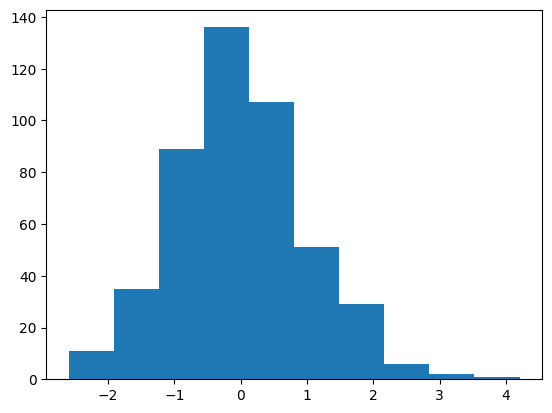

In [89]:
plt.hist(model_data['allCSF'])

### LV expansion and thalamic volumes

Does thalamic volume loss have regional relationships with expansion of the central CSF compartment?

**Steps**

1. Residualize out the effect of age, sex, TIV, and peripheral CSF volume from LV and each of the thalamic nuclei
2. Compute the Pearson correlations (r) between the residualized CP and each of the nuclei as well as the whole thalamus
3. Use the [Williams-Hotelling test](https://rdrr.io/github/bcdudek/bcdstats/man/test2r.t2.html) to compare the sizes of the r's (this procedure was used in Bergsland et al. 2020 as well)

In [14]:
disease_group = "MS"
influenced_var = "LV_log"
model_data = data.copy()[(MS_patients)]
model_data = zscore(model_data)

covariates = ["periCSF", "age", "Female", "tiv"]
results = thalamus_influence_analysis(model_data, influenced_var, covariates)

In [15]:
pearson_results, thalamus_comps, nuclei_comps = results
display(Markdown(f"##### Patients with {disease_group}"))

display(Markdown(f"**Pearson correlations of residualized thalamic nuclei and {influenced_var}:**"))
out_str = "```visualprolog\n"
for struct in pearson_results:
    out_str += f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


#! try to figure out why the diff option doesnt render with nbconvert even tho it works within vscode
display(Markdown("\n**Comparisons between thalamic nuclei and whole thalamus:**"))
out_str = "```diff\n"
for comp in thalamus_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={thalamus_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={thalamus_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


display(Markdown("\n**Comparisons between thalamic nuclei:**"))
out_str = "```diff\n"
for comp in nuclei_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={nuclei_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={nuclei_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))

##### Patients with MS

**Pearson correlations of residualized thalamic nuclei and LV_log:**

```visualprolog
THALAMUS_1: r=-0.629, p=6.50e-53
medial: r=-0.671, p=1.45e-62
posterior: r=-0.613, p=1.51e-49
anterior: r=-0.375, p=4.74e-17
ventral: r=-0.416, p=5.06e-21
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
+ medial > THALAMUS_1: p=2.34e-03
  posterior = THALAMUS_1: p=2.06e-01
- anterior < THALAMUS_1: p=8.59e-16
- ventral < THALAMUS_1: p=6.24e-32
```



**Comparisons between thalamic nuclei:**

```diff
+ medial > posterior: p=1.65e-03
+ medial > anterior: p=6.41e-19
+ medial > ventral: p=7.99e-22
+ posterior > anterior: p=1.47e-12
+ posterior > ventral: p=1.18e-11
  anterior = ventral: p=2.77e-01
```


#### Test the same in all the disease groups

---

In [ ]:
group_data = {
    "all": data.copy(),
    "!MS": data.copy()[(NONMS_patients)],
    "RMS": data.copy()[(RMS_patients)],
    "PMS": data.copy()[(PMS_patients)],
    "NIND": data.copy()[(NIND_patients)],
    "OIND": data.copy()[(OIND_patients)],
}

influenced_var = "LV_log"
covariates = ["periCSF", "age", "Female", "tiv"]

group_results = {}
for disease_group, model_data in group_data.items():
    print(disease_group)
    group_results[disease_group] = thalamus_influence_analysis(model_data, influenced_var, covariates)
    
clear_output(wait=False)

In [ ]:
for disease_group in group_data.keys():
    pearson_results, thalamus_comps, nuclei_comps = group_results[disease_group]
    display(Markdown(f"##### {disease_group.upper()} Patients"))

    display(Markdown(f"**Pearson correlations of residualized thalamic nuclei and {influenced_var}:**"))
    out_str = "```visualprolog\n"
    for struct in pearson_results:
        out_str += f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}\n"
    out_str += "```\n"
    display(Markdown(out_str))


    #! try to figure out why the diff option doesnt render with nbconvert even tho it works within vscode
    display(Markdown("\n**Comparisons between thalamic nuclei and whole thalamus:**"))
    out_str = "```diff\n"
    for comp in thalamus_comps:
        if re.match(r"\w+ [>] \w+", comp):
            prefix = "+"
        elif re.match(r"\w+ [<] \w+", comp):
            prefix = "-"
        else:
            prefix = " "
        out_str += f"{prefix} {comp}: p={thalamus_comps[comp]:0.2e}\n"
        # out_str += f"{comp}: p={thalamus_comps[comp]:0.2e}\n"
    out_str += "```\n"
    display(Markdown(out_str))


    display(Markdown("\n**Comparisons between thalamic nuclei:**"))
    out_str = "```diff\n"
    for comp in nuclei_comps:
        if re.match(r"\w+ [>] \w+", comp):
            prefix = "+"
        elif re.match(r"\w+ [<] \w+", comp):
            prefix = "-"
        else:
            prefix = " "
        out_str += f"{prefix} {comp}: p={nuclei_comps[comp]:0.2e}\n"
        # out_str += f"{comp}: p={nuclei_comps[comp]:0.2e}\n"
    out_str += "```\n"
    display(Markdown(out_str))

##### ALL Patients

**Pearson correlations of residualized thalamic nuclei and LV_log:**

```visualprolog
THALAMUS_1: r=-0.621, p=2.55e-61
medial: r=-0.662, p=3.00e-72
posterior: r=-0.613, p=1.74e-59
anterior: r=-0.359, p=1.34e-18
ventral: r=-0.398, p=7.79e-23
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
+ medial > THALAMUS_1: p=1.08e-03
  posterior = THALAMUS_1: p=5.28e-01
- anterior < THALAMUS_1: p=5.52e-19
- ventral < THALAMUS_1: p=6.96e-39
```



**Comparisons between thalamic nuclei:**

```diff
+ medial > posterior: p=3.85e-03
+ medial > anterior: p=4.09e-22
+ medial > ventral: p=7.51e-27
+ posterior > anterior: p=2.35e-16
+ posterior > ventral: p=1.42e-15
  anterior = ventral: p=2.66e-01
```


##### !MS Patients

**Pearson correlations of residualized thalamic nuclei and LV_log:**

```visualprolog
THALAMUS_1: r=-0.431, p=1.80e-05
medial: r=-0.446, p=8.23e-06
posterior: r=-0.516, p=1.37e-07
anterior: r=-0.219, p=3.57e-02
ventral: r=-0.109, p=3.01e-01
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
  medial = THALAMUS_1: p=7.15e-01
+ posterior > THALAMUS_1: p=3.52e-02
- anterior < THALAMUS_1: p=3.05e-02
- ventral < THALAMUS_1: p=1.31e-08
```



**Comparisons between thalamic nuclei:**

```diff
  medial = posterior: p=1.72e-01
+ medial > anterior: p=4.01e-02
+ medial > ventral: p=5.44e-05
+ posterior > anterior: p=4.64e-03
+ posterior > ventral: p=4.59e-06
  anterior = ventral: p=2.72e-01
```


##### RMS Patients

**Pearson correlations of residualized thalamic nuclei and LV_log:**

```visualprolog
THALAMUS_1: r=-0.578, p=2.12e-34
medial: r=-0.629, p=2.49e-42
posterior: r=-0.582, p=4.49e-35
anterior: r=-0.332, p=5.15e-11
ventral: r=-0.346, p=7.43e-12
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
+ medial > THALAMUS_1: p=2.48e-03
  posterior = THALAMUS_1: p=7.57e-01
- anterior < THALAMUS_1: p=2.64e-11
- ventral < THALAMUS_1: p=1.19e-25
```



**Comparisons between thalamic nuclei:**

```diff
+ medial > posterior: p=3.48e-02
+ medial > anterior: p=2.25e-14
+ medial > ventral: p=1.38e-18
+ posterior > anterior: p=1.71e-10
+ posterior > ventral: p=7.29e-12
  anterior = ventral: p=7.56e-01
```


##### PMS Patients

**Pearson correlations of residualized thalamic nuclei and LV_log:**

```visualprolog
THALAMUS_1: r=-0.757, p=4.63e-19
medial: r=-0.782, p=5.30e-21
posterior: r=-0.703, p=1.48e-15
anterior: r=-0.478, p=8.43e-07
ventral: r=-0.595, p=1.59e-10
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
  medial = THALAMUS_1: p=2.96e-01
- posterior < THALAMUS_1: p=2.45e-02
- anterior < THALAMUS_1: p=7.54e-06
- ventral < THALAMUS_1: p=6.56e-07
```



**Comparisons between thalamic nuclei:**

```diff
+ medial > posterior: p=2.28e-02
+ medial > anterior: p=4.17e-06
+ medial > ventral: p=7.35e-05
+ posterior > anterior: p=8.46e-04
+ posterior > ventral: p=4.67e-02
  anterior = ventral: p=1.30e-01
```


##### NIND Patients

**Pearson correlations of residualized thalamic nuclei and LV_log:**

```visualprolog
THALAMUS_1: r=-0.281, p=5.04e-02
medial: r=-0.311, p=2.98e-02
posterior: r=-0.362, p=1.06e-02
anterior: r=-0.0971, p=5.07e-01
ventral: r=0.0397, p=7.86e-01
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
  medial = THALAMUS_1: p=6.91e-01
  posterior = THALAMUS_1: p=2.01e-01
  anterior = THALAMUS_1: p=2.16e-01
- ventral < THALAMUS_1: p=8.67e-05
```



**Comparisons between thalamic nuclei:**

```diff
  medial = posterior: p=5.39e-01
  medial = anterior: p=2.28e-01
+ medial > ventral: p=5.92e-03
  posterior = anterior: p=1.12e-01
+ posterior > ventral: p=2.28e-03
  anterior = ventral: p=3.23e-01
```


##### OIND Patients

**Pearson correlations of residualized thalamic nuclei and LV_log:**

```visualprolog
THALAMUS_1: r=-0.497, p=9.44e-04
medial: r=-0.538, p=2.84e-04
posterior: r=-0.584, p=6.17e-05
anterior: r=-0.276, p=8.06e-02
ventral: r=-0.22, p=1.66e-01
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
  medial = THALAMUS_1: p=3.98e-01
  posterior = THALAMUS_1: p=8.77e-02
  anterior = THALAMUS_1: p=1.18e-01
- ventral < THALAMUS_1: p=5.20e-05
```



**Comparisons between thalamic nuclei:**

```diff
  medial = posterior: p=4.94e-01
  medial = anterior: p=7.84e-02
+ medial > ventral: p=1.61e-03
+ posterior > anterior: p=3.87e-02
+ posterior > ventral: p=9.71e-04
  anterior = ventral: p=7.04e-01
```


#### Check influence of CP

In [35]:
disease_group = "MS"
influenced_var = "T2LV_log1p"
model_data = data.copy()[(MS_patients)]
model_data = zscore(model_data)

covariates = ["WBV", "age", "Female", "tiv"]
results = thalamus_influence_analysis(model_data, influenced_var, covariates)

In [36]:
pearson_results, thalamus_comps, nuclei_comps = results
display(Markdown(f"##### Patients with {disease_group}"))

display(Markdown(f"**Pearson correlations of residualized thalamic nuclei and {influenced_var}:**"))
out_str = "```visualprolog\n"
for struct in pearson_results:
    out_str += f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


#! try to figure out why the diff option doesnt render with nbconvert even tho it works within vscode
display(Markdown("\n**Comparisons between thalamic nuclei and whole thalamus:**"))
out_str = "```diff\n"
for comp in thalamus_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={thalamus_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={thalamus_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


display(Markdown("\n**Comparisons between thalamic nuclei:**"))
out_str = "```diff\n"
for comp in nuclei_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={nuclei_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={nuclei_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))

##### Patients with MS

**Pearson correlations of residualized thalamic nuclei and T2LV_log1p:**

```visualprolog
THALAMUS_1: r=-0.501, p=3.76e-31
medial: r=-0.418, p=3.36e-21
posterior: r=-0.532, p=1.30e-35
anterior: r=-0.379, p=1.96e-17
ventral: r=-0.313, p=4.56e-12
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
- medial < THALAMUS_1: p=2.11e-04
  posterior = THALAMUS_1: p=1.02e-01
- anterior < THALAMUS_1: p=1.91e-03
- ventral < THALAMUS_1: p=6.74e-14
```



**Comparisons between thalamic nuclei:**

```diff
- medial < posterior: p=6.63e-05
  medial = anterior: p=3.84e-01
+ medial > ventral: p=8.35e-03
+ posterior > anterior: p=1.73e-04
+ posterior > ventral: p=1.98e-08
  anterior = ventral: p=1.40e-01
```


---

#### Compare all nuclei to Thalamus

In [ ]:
disease_group = "MS"
influenced_var = "LV_log"
model_data = data.copy()[(MS_patients)]
model_data = zscore(model_data)

covariates = ["periCSF", "age", "Female", "tiv"]
results = thalamus_influence_analysis_all_nuclei(model_data, influenced_var, covariates)

In [11]:
pearson_results, thalamus_comps = results
display(Markdown(f"##### Patients with {disease_group}"))

display(Markdown(f"**Pearson correlations of residualized thalamic nuclei and {influenced_var}:**"))
out_str = "```visualprolog\n"
for struct in pearson_results:
    out_str += f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


#! try to figure out why the diff option doesnt render with nbconvert even tho it works within vscode
display(Markdown("\n**Comparisons between thalamic nuclei and whole thalamus:**"))
out_str = "```diff\n"
for comp in thalamus_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={thalamus_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={thalamus_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


##### Patients with MS

**Pearson correlations of residualized thalamic nuclei and LV_log:**

```visualprolog
THALAMUS_1: r=-0.629, p=8.85e-53
AV_2: r=-0.375, p=5.23e-17
VA_4: r=-0.232, p=4.07e-07
VLa_5: r=-0.203, p=1.02e-05
VLP_6: r=-0.419, p=2.51e-21
VPL_7: r=-0.389, p=2.67e-18
Pul_8: r=-0.6, p=6.25e-47
LGN_9: r=-0.543, p=3.82e-37
MGN_10: r=-0.537, p=2.63e-36
CM_11: r=-0.478, p=4.58e-28
MD_Pf_12: r=-0.665, p=8.17e-61
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
- AV_2 < THALAMUS_1: p=9.36e-16
- VA_4 < THALAMUS_1: p=6.92e-33
- VLa_5 < THALAMUS_1: p=6.61e-32
- VLP_6 < THALAMUS_1: p=2.65e-23
- VPL_7 < THALAMUS_1: p=3.33e-25
- Pul_8 < THALAMUS_1: p=3.05e-02
- LGN_9 < THALAMUS_1: p=1.94e-03
- MGN_10 < THALAMUS_1: p=3.18e-04
- CM_11 < THALAMUS_1: p=4.66e-07
+ MD_Pf_12 > THALAMUS_1: p=1.65e-02
```


### PRL Count

In [9]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])
predictors = ["medial", "posterior", "ventral", "anterior"]
outcome = "PRL"

test_covariates = {
    "basic": ["age", "Female", "tiv"],
    "add WTV": ["WTV", "age", "Female", "tiv"],
}
results = {}
for model_name, covariates in test_covariates.items():
    results[model_name], _, _ = regutils.run_regressions(
        model_data, outcome, predictors, covariates=covariates, regression_model="GLM"
    )

# views = test_covariates.keys() #* all views
views = ["basic", "add WTV"]
for name in views:
    result = results[name]
    covariates = test_covariates[name]
    formula = regutils.formula_string(outcome, "*predictor*", covariates)
    display_order = result["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```R
PRL ~ *predictor* + age + Female + tiv
```


| predictor   |    coef |   p_fdr |     se | ci               |   R2 |
|:------------|--------:|--------:|-------:|:-----------------|-----:|
| posterior   | -0.6261 | 5.6e-24 | 0.0612 | [-0.746, -0.506] | 0.47 |
| medial      | -0.5472 | 3.1e-11 | 0.0811 | [-0.706, -0.388] | 0.4  |
| ventral     | -0.5394 | 4.1e-11 | 0.0812 | [-0.699, -0.38]  | 0.37 |
| anterior    | -0.5112 | 8.7e-09 | 0.0888 | [-0.685, -0.337] | 0.37 |

```R
PRL ~ *predictor* + WTV + age + Female + tiv
```


| predictor   |    coef |   p_fdr |     se | ci              |   R2 |
|:------------|--------:|--------:|-------:|:----------------|-----:|
| posterior   | -0.9055 |   3e-05 | 0.202  | [-1.3, -0.51]   | 0.48 |
| ventral     |  0.4319 |   0.087 | 0.2142 | [0.0122, 0.852] | 0.44 |
| medial      |  0.1395 |   0.61  | 0.2756 | [-0.401, 0.68]  | 0.43 |
| anterior    | -0.1182 |   0.41  | 0.1162 | [-0.346, 0.11]  | 0.43 |

### MS Status

The medial nuclei did not predict MS status after controlling for global thalamic atrophy, suggesting that the medial nuclei atrophy at the same rate as the whole structure. MS is associated with relative preservation of ventral nuclei (positive β), and disproportionate atrophy of the posterior and anterior nuclei. 

In [ ]:
model_data = data.copy()[(MS_patients) | (NONMS_patients)]
model_data = zscore(model_data)
model_data = model_data.join([pd.get_dummies(model_data['dz_type2'], dtype=int)])

outcome = "MS" # LV / allCSF
covariates = ["THALAMUS_1", "CP", "age", "Female", "tiv"]

save_cols = ["coef", "ci", "p_fdr"]
    
predictors = {
    "medial": ["medial"],
    "posterior": ["posterior"],
    "ventral": ["ventral"],
    "anterior": ["anterior"],
}
    
results, _, _ = regutils.run_regressions(
    model_data,
    [outcome],
    grouped_nuclei,
    covariates,
    regression_model=sm.Logit
)

results_to_display = results["MS"]
display(Markdown(f"`MS ~ predictor + {" + ".join(covariates)}`"))
display(
    Markdown(regutils.present_model(results_to_display, presentation_cols).to_markdown())
    )

results, models, formulas = regutils.run_regressions2(
    model_data,
    outcome,
    predictors.values(),
    covariates=covariates,
    model_names=predictors.keys(),
    regression_model=sm.Logit
)

for model_name, model, formula in zip(
    results.keys(), results.values(), formulas.values()
):
    display(Markdown(f"#### {model_name}"))
    display(Markdown(f"`{formula}`"))
    display(Markdown(regutils.present_model(model, presentation_cols, rename_index=nuclei_rename_index).to_markdown()))
    
    

`MS ~ predictor + THALAMUS_1 + CP + age + Female + tiv`

| predictor   |    coef |   pval |   p_fdr |     se | ci                | R2   |
|:------------|--------:|-------:|--------:|-------:|:------------------|:-----|
| medial      | -0.018  | 0.96   |  0.96   | 0.3794 | [-0.762, 0.726]   |      |
| posterior   | -1.4295 | 0.0012 |  0.0049 | 0.4418 | [-2.3, -0.564]    |      |
| ventral     |  0.9197 | 0.0075 |  0.015  | 0.3437 | [0.246, 1.59]     |      |
| anterior    | -0.3625 | 0.042  |  0.056  | 0.1784 | [-0.712, -0.0128] |      |

#### medial

`MS ~ medial + THALAMUS_1 + CP + age + Female + tiv`

|            |    coef |    pval |     se | ci               |
|:-----------|--------:|--------:|-------:|:-----------------|
| Intercept  |  1.9175 | 2e-39   | 0.146  | [1.63, 2.2]      |
| **medial** | -0.018  | 0.96    | 0.3794 | [-0.762, 0.726]  |
| THALAMUS_1 | -1.1598 | 0.0054  | 0.4167 | [-1.98, -0.343]  |
| CP         | -0.1097 | 0.47    | 0.1511 | [-0.406, 0.187]  |
| age        | -0.5078 | 0.00047 | 0.1452 | [-0.792, -0.223] |
| Female     | -0.1447 | 0.33    | 0.1497 | [-0.438, 0.149]  |
| tiv        |  0.2024 | 0.25    | 0.1774 | [-0.145, 0.55]   |

#### posterior

`MS ~ posterior + THALAMUS_1 + CP + age + Female + tiv`

|               |    coef |    pval |     se | ci               |
|:--------------|--------:|--------:|-------:|:-----------------|
| Intercept     |  1.9801 | 1.5e-38 | 0.1525 | [1.68, 2.28]     |
| **posterior** | -1.4295 | 0.0012  | 0.4418 | [-2.3, -0.564]   |
| THALAMUS_1    |  0.1994 | 0.67    | 0.4706 | [-0.723, 1.12]   |
| CP            | -0.1835 | 0.22    | 0.1498 | [-0.477, 0.11]   |
| age           | -0.5716 | 0.0001  | 0.1474 | [-0.86, -0.283]  |
| Female        | -0.2598 | 0.098   | 0.1572 | [-0.568, 0.0483] |
| tiv           | -0.0201 | 0.92    | 0.1929 | [-0.398, 0.358]  |

#### ventral

`MS ~ ventral + THALAMUS_1 + CP + age + Female + tiv`

|             |    coef |    pval |     se | ci               |
|:------------|--------:|--------:|-------:|:-----------------|
| Intercept   |  1.9557 | 6.4e-39 | 0.1499 | [1.66, 2.25]     |
| **ventral** |  0.9197 | 0.0075  | 0.3437 | [0.246, 1.59]    |
| THALAMUS_1  | -2.0051 | 3.2e-07 | 0.3922 | [-2.77, -1.24]   |
| CP          | -0.2491 | 0.11    | 0.1555 | [-0.554, 0.0558] |
| age         | -0.5333 | 0.00025 | 0.1457 | [-0.819, -0.248] |
| Female      | -0.2204 | 0.15    | 0.1537 | [-0.522, 0.0809] |
| tiv         |  0.0153 | 0.94    | 0.1912 | [-0.359, 0.39]   |

#### anterior

`MS ~ anterior + THALAMUS_1 + CP + age + Female + tiv`

|              |    coef |    pval |     se | ci                |
|:-------------|--------:|--------:|-------:|:------------------|
| Intercept    |  1.939  | 4.7e-39 | 0.1483 | [1.65, 2.23]      |
| **anterior** | -0.3625 | 0.042   | 0.1784 | [-0.712, -0.0128] |
| THALAMUS_1   | -0.9181 | 0.0004  | 0.2592 | [-1.43, -0.41]    |
| CP           | -0.0849 | 0.57    | 0.1483 | [-0.376, 0.206]   |
| age          | -0.6081 | 9.3e-05 | 0.1556 | [-0.913, -0.303]  |
| Female       | -0.1606 | 0.29    | 0.1508 | [-0.456, 0.135]   |
| tiv          |  0.1714 | 0.34    | 0.1779 | [-0.177, 0.52]    |

Compare influence of nuclei on predicting MS versus whole thalamus, and to eachother.

Issue here is that logistic regressions don't have residuals, so I had to use regular OLS when residualizing. 

In [ ]:
influenced_var = "MS"
model_data = data.copy()[(MS_patients) | (NONMS_patients)]
model_data = zscore(model_data)
model_data = model_data.join([pd.get_dummies(model_data['dz_type2'], dtype=int)])

covariates = ["age", "Female", "tiv"]
results2 = thalamus_influence_analysis(model_data, influenced_var, covariates)

In [ ]:
pearson_results, thalamus_comps, nuclei_comps = results2
display(Markdown("##### How do thalamic volumes predict MS"))

display(Markdown(f"**Pearson correlations of residualized thalamic nuclei and {influenced_var}:**"))
out_str = "```visualprolog\n"
for struct in pearson_results:
    out_str += f"{struct}: r={pearson_results[struct][0]:0.3}, p={pearson_results[struct][1]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


#! try to figure out why the diff option doesnt render with nbconvert even tho it works within vscode
display(Markdown("\n**Comparisons between thalamic nuclei and whole thalamus:**"))
out_str = "```diff\n"
for comp in thalamus_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={thalamus_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={thalamus_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))


display(Markdown("\n**Comparisons between thalamic nuclei:**"))
out_str = "```diff\n"
for comp in nuclei_comps:
    if re.match(r"\w+ [>] \w+", comp):
        prefix = "+"
    elif re.match(r"\w+ [<] \w+", comp):
        prefix = "-"
    else:
        prefix = " "
    out_str += f"{prefix} {comp}: p={nuclei_comps[comp]:0.2e}\n"
    # out_str += f"{comp}: p={nuclei_comps[comp]:0.2e}\n"
out_str += "```\n"
display(Markdown(out_str))

##### How do thalamic volumes predict MS

**Pearson correlations of residualized thalamic nuclei and MS:**

```visualprolog
THALAMUS_1: r=-0.225, p=7.11e-08
medial: r=-0.209, p=6.32e-07
posterior: r=-0.257, p=6.70e-10
anterior: r=-0.215, p=2.87e-07
ventral: r=-0.151, p=3.21e-04
```



**Comparisons between thalamic nuclei and whole thalamus:**

```diff
  medial = THALAMUS_1: p=2.95e-01
+ posterior > THALAMUS_1: p=2.99e-02
  anterior = THALAMUS_1: p=7.60e-01
- ventral < THALAMUS_1: p=2.91e-04
```



**Comparisons between thalamic nuclei:**

```diff
- medial < posterior: p=2.33e-02
  medial = anterior: p=8.71e-01
  medial = ventral: p=5.56e-02
  posterior = anterior: p=2.39e-01
+ posterior > ventral: p=7.45e-04
  anterior = ventral: p=8.64e-02
```


---

#### Overall thalamus size versus disease phenotype

Thalamus is smaller in MS patients

In [ ]:
model_data = data.copy()[(MS_patients) | (NONMS_patients)]
model_data = zscore(model_data)
model_data = model_data.join([pd.get_dummies(model_data['dz_type2'], dtype=int)])

res = sm.Logit.from_formula("MS ~ THALAMUS_1 + age + Female + tiv", data=model_data).fit(disp=0)
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:                     MS   No. Observations:                  560
Model:                          Logit   Df Residuals:                      555
Method:                           MLE   Df Model:                            4
Date:                Tue, 04 Nov 2025   Pseudo R-squ.:                 0.09205
Time:                        18:07:56   Log-Likelihood:                -227.13
converged:                       True   LL-Null:                       -250.16
Covariance Type:            nonrobust   LLR p-value:                 2.397e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9026      0.145     13.149      0.000       1.619       2.186
THALAMUS_1    -1.1011      0.208     -5.305      0.000      -1.508      -0.694
age           -0.5342      0.141     -3.788      0.0

Thalamus is smaller in PMS patients

In [ ]:
model_data = data.copy()[(MS_patients)]
model_data = zscore(model_data)
model_data = model_data.join([pd.get_dummies(model_data['dz_type5'], dtype=int)])

res = sm.Logit.from_formula("PMS ~ THALAMUS_1 + age + Female + tiv", data=model_data).fit(disp=0)
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:                    PMS   No. Observations:                  468
Model:                          Logit   Df Residuals:                      463
Method:                           MLE   Df Model:                            4
Date:                Tue, 04 Nov 2025   Pseudo R-squ.:                  0.2944
Time:                        18:05:52   Log-Likelihood:                -168.50
converged:                       True   LL-Null:                       -238.83
Covariance Type:            nonrobust   LLR p-value:                 2.056e-29
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0353      0.185    -11.021      0.000      -2.397      -1.673
THALAMUS_1    -0.7105      0.156     -4.554      0.000      -1.016      -0.405
age            1.2298      0.180      6.832      0.0

---

## Thalamus Diagrams

In [42]:
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
diagram_maker_home = Path("/home/srs-9/Projects/ms_mri/create_diagram")
df_thomas_left = utils.load_hipsthomas(data_dir, side="left")
df_thomas_right = utils.load_hipsthomas(data_dir, side="right")
df_thomas = utils.load_hipsthomas(data_dir, side=None)

# data_ms["HAS_PRL"] = data_ms["HAS_PRL"].cat.codes.astype("float")

left_data = data_ms[["CP", "CP_left", "CP_right", "age", "Female", "tiv", "dzdur", "CCR2_log", "WTV", "T2LV_log1p", "HAS_PRL", "PRL_LEVEL"]].join([df_thomas_left[hips_thomas_ref[thalamic_nuclei+[1]]]])
right_data = data_ms[["CP", "CP_left", "CP_right", "age", "Female", "tiv", "dzdur", "CCR2_log", "WTV", "T2LV_log1p", "HAS_PRL", "PRL_LEVEL"]].join([df_thomas_right[hips_thomas_ref[thalamic_nuclei+[1]]]])
bilateral_data = data_ms[["CP", "CP_left", "CP_right", "age", "Female", "tiv", "dzdur", "CCR2_log", "WTV", "T2LV_log1p", "HAS_PRL", "PRL_LEVEL"]].join([df_thomas[hips_thomas_ref[thalamic_nuclei+[1]]]])

# exclude_subs = [1248, 2051]
exclude_subs = []

left_data = left_data.loc[~left_data.index.isin(exclude_subs)]
right_data = right_data.loc[~right_data.index.isin(exclude_subs)]
bilateral_data = bilateral_data.loc[~bilateral_data.index.isin(exclude_subs)]

In [43]:
covariates = ["age", "Female", "tiv"]
outcomes = hips_thomas_ref[thalamic_nuclei]

nbins = 20

results = {}

predictor = ["CP"]
predictor_key = "CP"
model_data = zscore(bilateral_data)
_, res, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    predictor,
    covariates,
    to_check_vif=False,
    robust_cov="HC3",
)
results['bilateral'] = res[predictor_key].reset_index()

predictor = ["CP"]
predictor_key = "CP"
model_data = zscore(left_data)
_, res, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    predictor,
    covariates,
    to_check_vif=False,
    robust_cov="HC3",
)
results['left'] = res[predictor_key].reset_index()

predictor = ["CP"]
predictor_key = "CP"
model_data = zscore(right_data)
_, res, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    predictor,
    covariates,
    to_check_vif=False,
    robust_cov="HC3",
)
results['right'] = res[predictor_key].reset_index()

all_coefs = np.array(results['left']['coef'].to_list() + results['right']['coef'].to_list())
bins = np.linspace(all_coefs.min(), all_coefs.max(), nbins)
results['left']['coef_bin'] = np.digitize(results['left']['coef'], bins)
results['right']['coef_bin'] = np.digitize(results['right']['coef'], bins)

assignment_table = pd.DataFrame({
    "struct": results['left']['outcome'].to_list() + results['right']['outcome'].to_list(),
    "Side": ["L"]*len(results['left']) + ["R"]*len(results['right']),
    "struct_index": hips_thomas_invref[results['left']['outcome']].to_list() + hips_thomas_invref[results['right']['outcome']].to_list(),
    "bin": results['left']['coef_bin'].to_list() + results['right']['coef_bin'].to_list()
})
assignment_table.to_csv(diagram_maker_home / "color_assignments.csv")
print(all_coefs.min(), all_coefs.max())

-0.44070016207069257 -0.07249096165190617


Bin edges: [-0.44070016 -0.4222897  -0.40387924 -0.38546878 -0.36705832 -0.34864786
 -0.3302374  -0.31182694 -0.29341648 -0.27500602 -0.25659556 -0.2381851
 -0.21977464 -0.20136418 -0.18295372 -0.16454326 -0.1461328  -0.12772234
 -0.10931188 -0.09090142 -0.07249096]
Bin centers: [-0.43149493 -0.41308447 -0.39467401 -0.37626355 -0.35785309 -0.33944263
 -0.32103217 -0.30262171 -0.28421125 -0.26580079 -0.24739033 -0.22897987
 -0.21056941 -0.19215895 -0.17374849 -0.15533803 -0.13692757 -0.11851711
 -0.10010665 -0.08169619]
Zero is in bin index: 20

Number of negative bins: 20
Number of zero bins: 1
Number of positive bins: 0

RGB values (0-1 scale):
Bin 0: center=-0.431, RGB=(0.774, 0.200, 0.203)
Bin 1: center=-0.413, RGB=(0.806, 0.260, 0.231)
Bin 2: center=-0.395, RGB=(0.835, 0.314, 0.260)
Bin 3: center=-0.376, RGB=(0.857, 0.355, 0.285)
Bin 4: center=-0.358, RGB=(0.881, 0.402, 0.317)
Bin 5: center=-0.339, RGB=(0.903, 0.448, 0.350)
Bin 6: center=-0.321, RGB=(0.918, 0.484, 0.378)
Bin 7: cen

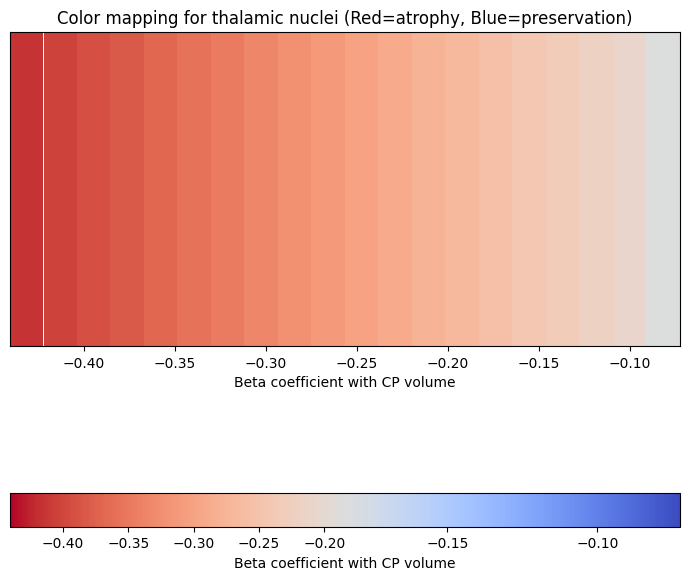


ALTERNATIVE: coolwarm colormap

RGB values (0-255 scale) with coolwarm:
Bin 0: center=-0.431, RGB=(197, 50, 51)
Bin 1: center=-0.413, RGB=(205, 66, 58)
Bin 2: center=-0.395, RGB=(212, 79, 66)
Bin 3: center=-0.376, RGB=(218, 90, 72)
Bin 4: center=-0.358, RGB=(224, 102, 80)
Bin 5: center=-0.339, RGB=(230, 114, 89)
Bin 6: center=-0.321, RGB=(234, 123, 96)
Bin 7: center=-0.303, RGB=(238, 134, 105)
Bin 8: center=-0.284, RGB=(241, 144, 114)
Bin 9: center=-0.266, RGB=(243, 152, 121)
Bin 10: center=-0.247, RGB=(245, 161, 130)
Bin 11: center=-0.229, RGB=(246, 170, 140)
Bin 12: center=-0.211, RGB=(247, 178, 149)
Bin 13: center=-0.192, RGB=(246, 185, 157)
Bin 14: center=-0.174, RGB=(245, 192, 167)
Bin 15: center=-0.155, RGB=(243, 198, 176)
Bin 16: center=-0.137, RGB=(241, 203, 184)
Bin 17: center=-0.119, RGB=(237, 208, 193)
Bin 18: center=-0.100, RGB=(232, 213, 202)
Bin 19: center=-0.082, RGB=(221, 220, 219)

ALTERNATIVE: spectral colormap

RGB values (0-255 scale) with coolwarm:
Bin 0: center=-

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

# Your beta range
beta_min, beta_max = all_coefs.min(), all_coefs.max()

# Create nbins evenly spaced bins
bins = np.linspace(beta_min, beta_max, nbins+1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Find which bin contains zero
zero_bin_idx = np.searchsorted(bin_centers, 0)

print(f"Bin edges: {bins}")
print(f"Bin centers: {bin_centers}")
print(f"Zero is in bin index: {zero_bin_idx}")

# Use RdBu (NOT reversed) - Red for negative (atrophy), Blue for positive (preservation)
cmap = plt.cm.coolwarm_r

# Create non-linear sampling to make colors more distinguishable
# We'll use more extreme values from the colormap for better distinction
n_neg = zero_bin_idx  # bins with negative values (3 bins)
n_pos = len(bin_centers) - zero_bin_idx  # bins with positive values (6 bins)

# Sample positions in colormap (0 to 1)
# For negative values: sample from 0 to 0.45 (reds)
# For zero: use 0.5 (white)
# For positive values: sample from 0.55 to 1.0 (blues)

color_positions = []

if n_neg > 0:
    # Negative bins - sample reds (0 to 0.45)
    neg_positions = np.linspace(0.05, 0.45, n_neg-1)
    color_positions.extend(neg_positions)

# Zero bin - center (white)
color_positions.append(0.5)

if n_pos > 0:
    # Positive bins - sample blues (0.55 to 1.0)
    pos_positions = np.linspace(0.55, 0.95, n_pos)
    color_positions.extend(pos_positions)

# Get RGB values
rgb_values = [cmap(pos) for pos in color_positions]

# Display the results
print(f"\nNumber of negative bins: {n_neg}")
print(f"Number of zero bins: 1")
print(f"Number of positive bins: {n_pos}")
print(f"\nRGB values (0-1 scale):")
for i, (center, rgb) in enumerate(zip(bin_centers, rgb_values)):
    print(f"Bin {i}: center={center:6.3f}, RGB=({rgb[0]:.3f}, {rgb[1]:.3f}, {rgb[2]:.3f})")

# Convert to 0-255 scale if needed
rgb_255 = [(int(r*255), int(g*255), int(b*255)) for r, g, b, a in rgb_values]
print(f"\nRGB values (0-255 scale):")
for i, (center, rgb) in enumerate(zip(bin_centers, rgb_255)):
    print(f"Bin {i}: center={center:6.3f}, RGB={rgb}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6))

# Show the color scale
for i, (center, rgb) in enumerate(zip(bin_centers, rgb_values)):
    ax1.add_patch(plt.Rectangle((center - (bins[1]-bins[0])/2, 0), 
                                 bins[1]-bins[0], 1, 
                                 facecolor=rgb[:3]))

ax1.set_xlim(beta_min, beta_max)
ax1.set_ylim(0, 1)
ax1.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Beta coefficient with CP volume')
ax1.set_title('Color mapping for thalamic nuclei (Red=atrophy, Blue=preservation)')
ax1.set_yticks([])

# Create a proper colorbar
norm = mcolors.TwoSlopeNorm(vmin=beta_min, vcenter=0, vmax=beta_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, orientation='horizontal')
cbar.set_label('Beta coefficient with CP volume')
ax2.remove()

plt.tight_layout()
plt.savefig(fig_path / 'colormap_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Also try coolwarm as an alternative
print("\n" + "="*60)
print("ALTERNATIVE: coolwarm colormap")
print("="*60)

cmap_alt = plt.cm.coolwarm
rgb_values_alt = [cmap_alt(1-pos) for pos in color_positions]
rgb_255_alt = [(int(r*255), int(g*255), int(b*255)) for r, g, b, a in rgb_values_alt]

print(f"\nRGB values (0-255 scale) with coolwarm:")
for i, (center, rgb) in enumerate(zip(bin_centers, rgb_255_alt)):
    print(f"Bin {i}: center={center:6.3f}, RGB={rgb}")


# Also try spectral as an alternative
print("\n" + "="*60)
print("ALTERNATIVE: spectral colormap")
print("="*60)

cmap_alt = plt.cm.Spectral
rgb_values_alt = [cmap_alt(pos) for pos in color_positions]
rgb_255_spectral = [(int(r*255), int(g*255), int(b*255)) for r, g, b, a in rgb_values_alt]

print(f"\nRGB values (0-255 scale) with coolwarm:")
for i, (center, rgb) in enumerate(zip(bin_centers, rgb_255_spectral)):
    print(f"Bin {i}: center={center:6.3f}, RGB={rgb}")

# Also try RdYlBu as an alternative
print("\n" + "="*60)
print("ALTERNATIVE: RdYlBu colormap")
print("="*60)

cmap_alt = plt.cm.RdYlBu
rgb_values_alt = [cmap_alt(pos) for pos in color_positions]
rgb_255_RdYlBu = [(int(r*255), int(g*255), int(b*255)) for r, g, b, a in rgb_values_alt]

print(f"\nRGB values (0-255 scale) with coolwarm:")
for i, (center, rgb) in enumerate(zip(bin_centers, rgb_255_RdYlBu)):
    print(f"Bin {i}: center={center:6.3f}, RGB={rgb}")

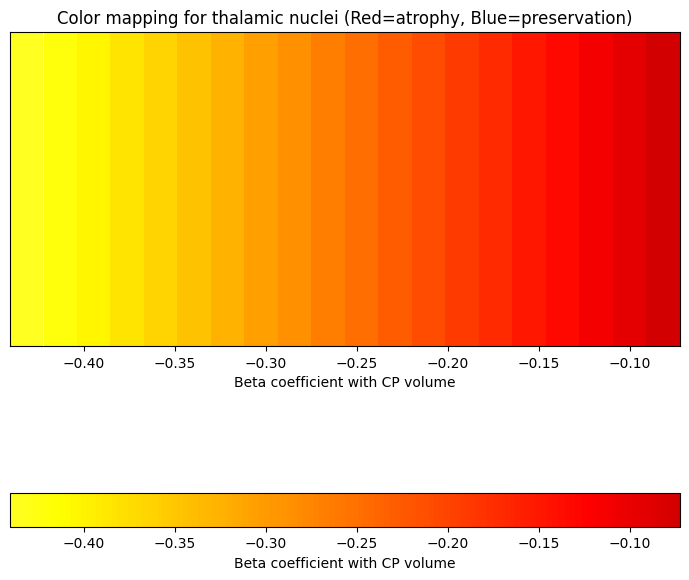

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

# Your beta range
beta_min, beta_max = all_coefs.min(), all_coefs.max()

# Create nbins evenly spaced bins
bins = np.linspace(beta_min, all_coefs.max(), nbins+1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Find which bin contains zero
zero_bin_idx = np.searchsorted(bin_centers, 0)

# Use RdBu (NOT reversed) - Red for negative (atrophy), Blue for positive (preservation)
cmap_full = plt.cm.hot_r
# Create a truncated colormap - only use the red half (0 to 0.5)
cmap = mcolors.LinearSegmentedColormap.from_list(
    'truncated_coolwarm_r',
    cmap_full(np.linspace(0.22, 0.7, 256))
)

# Create non-linear sampling to make colors more distinguishable
# We'll use more extreme values from the colormap for better distinction
n_neg = zero_bin_idx  # bins with negative values (3 bins)
n_pos = len(bin_centers) - zero_bin_idx  # bins with positive values (6 bins)

color_positions = np.linspace(0, 1, nbins)

# Get RGB values
rgb_values = [cmap(pos) for pos in color_positions]

# Display the results

# print(f"\nRGB values (0-1 scale):")
# for i, (center, rgb) in enumerate(zip(bin_centers, rgb_values)):
    # print(f"Bin {i}: center={center:6.3f}, RGB=({rgb[0]:.3f}, {rgb[1]:.3f}, {rgb[2]:.3f})")

# Convert to 0-255 scale if needed
rgb_255 = [(int(r*255), int(g*255), int(b*255)) for r, g, b, a in rgb_values]
# print(f"\nRGB values (0-255 scale):")
# for i, (center, rgb) in enumerate(zip(bin_centers, rgb_255)):
#     print(f"Bin {i}: center={center:6.3f}, RGB={rgb}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6))

# Show the color scale
for i, (center, rgb) in enumerate(zip(bin_centers, rgb_values)):
    ax1.add_patch(plt.Rectangle((center - (bins[1]-bins[0])/2, 0), 
                                 bins[1]-bins[0], 1, 
                                 facecolor=rgb[:3]))

ax1.set_xlim(beta_min, beta_max)
ax1.set_ylim(0, 1)
ax1.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Beta coefficient with CP volume')
ax1.set_title('Color mapping for thalamic nuclei (Red=atrophy, Blue=preservation)')
ax1.set_yticks([])

# Create a proper colorbar
norm = mcolors.Normalize(vmin=beta_min, vmax=beta_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, orientation='horizontal')
cbar.set_label('Beta coefficient with CP volume')
ax2.remove()

plt.tight_layout()
plt.savefig(fig_path / 'colormap_visualization_half-YlOrRd.png', dpi=300, bbox_inches='tight')
plt.show()

In [75]:
color_positions

[np.float64(0.0),
 np.float64(0.030555555555555558),
 np.float64(0.061111111111111116),
 np.float64(0.09166666666666667),
 np.float64(0.12222222222222223),
 np.float64(0.1527777777777778),
 np.float64(0.18333333333333335),
 np.float64(0.2138888888888889),
 np.float64(0.24444444444444446),
 np.float64(0.275),
 np.float64(0.3055555555555556),
 np.float64(0.33611111111111114),
 np.float64(0.3666666666666667),
 np.float64(0.39722222222222225),
 np.float64(0.4277777777777778),
 np.float64(0.45833333333333337),
 np.float64(0.48888888888888893),
 np.float64(0.5194444444444445),
 np.float64(0.55),
 0.6]

In [116]:
out_txt = "bin,R,G,B\n"
for i, rgb in enumerate(rgb_255):
    out_txt += f"{i+1},{rgb[0]},{rgb[1]},{rgb[2]}\n"

    create_diagram_path = Path("/home/srs-9/Projects/ms_mri/create_diagram")
with open(create_diagram_path / "color_reference_hot_CP.csv", 'w') as f:
    f.write(out_txt)

In [ ]:
results['bilateral']

In [ ]:
results['left']

In [ ]:
results['right']

In [117]:
%%bash
fig_name=struct_vs_CP_basic_control.png
fig_path="$HOME/Projects/ms_mri/analysis/thalamus/results/figures_tables/4-CP_and_medial_posterior_atrophy"
save_path="$fig_path/$fig_name"
create_diagram_home=$HOME/Projects/ms_mri/create_diagram

docker run --rm -v "$create_diagram_home:/app" diagram-maker color_assignments.csv  
mv $create_diagram_home/thalamus_diagram.png $save_path

## Extras

In [17]:
model_data = data_ms_z
# model_data = zscore(dataT[MS_patients])
save_path = fig_path / "combined_nuclei_thalamus_control_by_struct.xlsx"
covariates = ["THALAMUS_1", "age", "Female", "tiv"]

outcomes = [
    "medial",
    "posterior",
    "ventral",
    "anterior"
]

predictor = ["CP", "t2lv_log", "PRL", "LV_log", "thirdV_log", "CCR"]
# predictor = ["CP", "t2lv", "PRL", "LV", "thirdV", "CCR"]


results, _, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictor,
    covariates,
)

for outcome_to_display in outcomes:
    results_to_display = results[outcome_to_display]
    display_order = results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"`{outcome_to_display} ~ *predictor* + {" + ".join(covariates)}`"))
    display(
        Markdown(regutils.present_model(results_to_display, presentation_cols).to_markdown())
    )

CP, THALAMUS_1, age, Female, tiv, medial
t2lv_log, THALAMUS_1, age, Female, tiv, medial
PRL, THALAMUS_1, age, Female, tiv, medial
LV_log, THALAMUS_1, age, Female, tiv, medial
thirdV_log, THALAMUS_1, age, Female, tiv, medial
CCR, THALAMUS_1, age, Female, tiv, medial
CP, THALAMUS_1, age, Female, tiv, posterior
t2lv_log, THALAMUS_1, age, Female, tiv, posterior
PRL, THALAMUS_1, age, Female, tiv, posterior
LV_log, THALAMUS_1, age, Female, tiv, posterior
thirdV_log, THALAMUS_1, age, Female, tiv, posterior
CCR, THALAMUS_1, age, Female, tiv, posterior
CP, THALAMUS_1, age, Female, tiv, ventral
t2lv_log, THALAMUS_1, age, Female, tiv, ventral
PRL, THALAMUS_1, age, Female, tiv, ventral
LV_log, THALAMUS_1, age, Female, tiv, ventral
thirdV_log, THALAMUS_1, age, Female, tiv, ventral
CCR, THALAMUS_1, age, Female, tiv, ventral


`medial ~ *predictor* + THALAMUS_1 + age + Female + tiv`

| predictor   |    coef |   p_fdr |     se | ci                |   R2 |
|:------------|--------:|--------:|-------:|:------------------|-----:|
| CP          | -0.0739 | 0.00056 | 0.0203 | [-0.114, -0.034]  | 0.89 |
| t2lv_log    | -0.0206 | 0.36    | 0.0198 | [-0.0594, 0.0182] | 0.89 |
| PRL         |  0.0131 | 0.52    | 0.0202 | [-0.0264, 0.0527] | 0.89 |
| LV_log      | -0.151  | 2.3e-11 | 0.0217 | [-0.194, -0.108]  | 0.9  |
| thirdV_log  | -0.0635 | 0.0058  | 0.022  | [-0.107, -0.0205] | 0.89 |
| CCR         | -0.123  | 9.3e-07 | 0.024  | [-0.17, -0.0759]  | 0.9  |

`posterior ~ *predictor* + THALAMUS_1 + age + Female + tiv`

| predictor   |    coef |   p_fdr |     se | ci                  |   R2 |
|:------------|--------:|--------:|-------:|:--------------------|-----:|
| CP          | -0.0459 |  0.02   | 0.0178 | [-0.0809, -0.0109]  | 0.9  |
| t2lv_log    | -0.0709 |  0.0021 | 0.0203 | [-0.111, -0.0311]   | 0.91 |
| PRL         | -0.06   |  0.0021 | 0.0177 | [-0.0947, -0.0253]  | 0.91 |
| LV_log      | -0.0469 |  0.037  | 0.0209 | [-0.0877, -0.00597] | 0.9  |
| thirdV_log  |  0.0164 |  0.4    | 0.0195 | [-0.0217, 0.0546]   | 0.9  |
| CCR         | -0.0228 |  0.38   | 0.0227 | [-0.0673, 0.0218]   | 0.9  |

`ventral ~ *predictor* + THALAMUS_1 + age + Female + tiv`

| predictor   |   coef |   p_fdr |     se | ci                 |   R2 |
|:------------|-------:|--------:|-------:|:-------------------|-----:|
| CP          | 0.1309 | 6.8e-11 | 0.0196 | [0.0925, 0.169]    | 0.87 |
| t2lv_log    | 0.0864 | 0.00087 | 0.0256 | [0.0363, 0.137]    | 0.87 |
| PRL         | 0.0295 | 0.11    | 0.0185 | [-0.00675, 0.0658] | 0.86 |
| LV_log      | 0.2    | 3.3e-14 | 0.0256 | [0.15, 0.25]       | 0.88 |
| thirdV_log  | 0.101  | 5.3e-05 | 0.0244 | [0.0531, 0.149]    | 0.87 |
| CCR         | 0.1467 | 7.5e-08 | 0.0267 | [0.0944, 0.199]    | 0.88 |

`anterior ~ *predictor* + THALAMUS_1 + age + Female + tiv`

| predictor   |    coef |   p_fdr |     se | ci                 |   R2 |
|:------------|--------:|--------:|-------:|:-------------------|-----:|
| CP          |  0.0428 |  0.38   | 0.0439 | [-0.0432, 0.129]   | 0.56 |
| t2lv_log    | -0.0878 |  0.084  | 0.04   | [-0.166, -0.00941] | 0.57 |
| PRL         | -0.0474 |  0.21   | 0.0294 | [-0.105, 0.0102]   | 0.56 |
| LV_log      |  0.051  |  0.38   | 0.0494 | [-0.0459, 0.148]   | 0.56 |
| thirdV_log  | -0.1518 |  0.0015 | 0.0414 | [-0.233, -0.0708]  | 0.57 |
| CCR         |  0.0458 |  0.38   | 0.0518 | [-0.0557, 0.147]   | 0.56 |

In [ ]:
model_data = data_ms_z
save_path = fig_path / "combined_nuclei_thalamus_control.xlsx"
covariates = ["THALAMUS_1", "age", "Female", "tiv"]

outcomes = [
    "medial",
    "posterior",
    "ventral",
    "anterior"
]

predictor = ["CP", "t2lv_log", "LV_log", "thirdV_log", "periCSF"]

_, results, models = regutils.run_regressions(
    model_data,
    outcomes,
    predictor,
    covariates,
)

save_cols = ["coef", "ci", "p_fdr"]
with pd.ExcelWriter(save_path) as writer:
    for predictor in results:
        save_results = results[predictor][save_cols]
        save_results.to_excel(writer, sheet_name=predictor)


for outcome_to_display in ["CP", "LV_log", "t2lv_log"]:
    results_to_display = results[outcome_to_display]
    display_order = results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"`outcome ~ *{outcome_to_display}* + {" + ".join(covariates)}`"))
    display(
        Markdown(regutils.present_model(results_to_display, presentation_cols).to_markdown())
    )

`outcome ~ *CP* + THALAMUS_1 + age + Female + tiv`

| outcome   |    coef |    pval |   p_fdr |     se | ci                 |   R2 |
|:----------|--------:|--------:|--------:|-------:|:-------------------|-----:|
| medial    | -0.0758 | 0.00021 | 0.00043 | 0.0203 | [-0.116, -0.0359]  | 0.89 |
| posterior | -0.0453 | 0.012   | 0.016   | 0.0179 | [-0.0804, -0.0101] | 0.9  |
| ventral   |  0.1292 | 1.3e-10 | 5.4e-10 | 0.0197 | [0.0906, 0.168]    | 0.87 |
| anterior  |  0.037  | 0.4     | 0.4     | 0.0439 | [-0.0493, 0.123]   | 0.56 |

`outcome ~ *LV_log* + THALAMUS_1 + age + Female + tiv`

| outcome   |    coef |    pval |   p_fdr |     se | ci                 |   R2 |
|:----------|--------:|--------:|--------:|-------:|:-------------------|-----:|
| medial    | -0.1559 | 1.6e-11 | 3.2e-11 | 0.0226 | [-0.2, -0.112]     | 0.9  |
| posterior | -0.0532 | 0.013   | 0.017   | 0.0213 | [-0.0951, -0.0113] | 0.9  |
| ventral   |  0.1981 | 1.7e-15 | 6.8e-15 | 0.024  | [0.151, 0.245]     | 0.88 |
| anterior  |  0.061  | 0.22    | 0.22    | 0.0496 | [-0.0364, 0.158]   | 0.56 |

`outcome ~ *t2lv_log* + THALAMUS_1 + age + Female + tiv`

| outcome   |    coef |    pval |   p_fdr |     se | ci                 |   R2 |
|:----------|--------:|--------:|--------:|-------:|:-------------------|-----:|
| medial    | -0.0191 | 0.33    | 0.33    | 0.0197 | [-0.0579, 0.0197]  | 0.89 |
| posterior | -0.0712 | 0.00048 | 0.00098 | 0.0203 | [-0.111, -0.0314]  | 0.91 |
| ventral   |  0.09   | 0.00049 | 0.00098 | 0.0256 | [0.0396, 0.14]     | 0.87 |
| anterior  | -0.0825 | 0.04    | 0.053   | 0.0401 | [-0.161, -0.00376] | 0.57 |

In [ ]:
model_data = data_ms_z
save_path = fig_path / "combined_nuclei_thalamus_periCSF_control.xlsx"
covariates = ["THALAMUS_1", "periCSF", "age", "Female", "tiv"]

outcomes = [
    "medial",
    "posterior",
    "ventral",
    "anterior"
]

predictor = ["CP", "LV_log", "brain", "white", "grey", "cortical_thickness", "t2lv_log"]

_, results, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    predictor,
    covariates,
)

save_cols = ["coef", "ci", "p_fdr"]
with pd.ExcelWriter(save_path) as writer:
    for predictor in results:
        save_results = results[predictor][save_cols]
        save_results.to_excel(writer, sheet_name=predictor)


for outcome_to_display in ["CP", "LV_log", "t2lv_log"]:
    results_to_display = results[outcome_to_display]
    display_order = results_to_display["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"`struct ~ *{outcome_to_display}* + {" + ".join(covariates)}`"))
    display(
        Markdown(regutils.present_model(results_to_display, presentation_cols).to_markdown())
    )

`struct ~ *CP* + THALAMUS_1 + periCSF + age + Female + tiv`

| outcome   |    coef |    pval |   p_fdr |     se | ci                 |   R2 |
|:----------|--------:|--------:|--------:|-------:|:-------------------|-----:|
| medial    | -0.0793 | 0.00015 | 0.00029 | 0.0207 | [-0.12, -0.0386]   | 0.89 |
| posterior | -0.0506 | 0.0047  | 0.0063  | 0.0178 | [-0.0856, -0.0156] | 0.91 |
| ventral   |  0.1367 | 2.4e-11 | 9.7e-11 | 0.02   | [0.0975, 0.176]    | 0.88 |
| anterior  |  0.037  | 0.41    | 0.41    | 0.0446 | [-0.0507, 0.125]   | 0.56 |

`struct ~ *LV_log* + THALAMUS_1 + periCSF + age + Female + tiv`

| outcome   |    coef |    pval |   p_fdr |     se | ci                  |   R2 |
|:----------|--------:|--------:|--------:|-------:|:--------------------|-----:|
| medial    | -0.1563 | 1.5e-11 | 2.9e-11 | 0.0226 | [-0.201, -0.112]    | 0.9  |
| posterior | -0.046  | 0.036   | 0.048   | 0.0218 | [-0.0889, -0.00305] | 0.9  |
| ventral   |  0.1935 | 6e-14   | 2.4e-13 | 0.025  | [0.144, 0.243]      | 0.88 |
| anterior  |  0.0646 | 0.19    | 0.19    | 0.0497 | [-0.0331, 0.162]    | 0.56 |

`struct ~ *t2lv_log* + THALAMUS_1 + periCSF + age + Female + tiv`

| outcome   |    coef |    pval |   p_fdr |     se | ci                 |   R2 |
|:----------|--------:|--------:|--------:|-------:|:-------------------|-----:|
| medial    | -0.0172 | 0.39    |  0.39   | 0.0198 | [-0.0561, 0.0218]  | 0.89 |
| posterior | -0.0673 | 0.00084 |  0.0017 | 0.02   | [-0.107, -0.0279]  | 0.91 |
| ventral   |  0.0854 | 0.0008  |  0.0017 | 0.0253 | [0.0357, 0.135]    | 0.87 |
| anterior  | -0.0827 | 0.039   |  0.052  | 0.04   | [-0.161, -0.00406] | 0.56 |